# Свёрточные нейронные сети в Pytorch

# Cвёрточные нейронные сети

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision


def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[..., ::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()


def show_grayscale_image(image, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Создадим свёртку
## Параметры:
*   вход: 1 канал;
*   выход: 1 канал;
*   размер ядра: 3×3.

In [3]:
layer = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

In [4]:
layer.weight

Parameter containing:
tensor([[[[-0.0904, -0.1102,  0.0617],
          [ 0.2563, -0.2714,  0.1926],
          [ 0.0144,  0.0105, -0.0951]]]], requires_grad=True)

In [5]:
layer.weight.shape

torch.Size([1, 1, 3, 3])

# Модифицируем веса

In [6]:
# веса доступны через .weight.data
# изменим веса так, чтобы все они были одинаковыми и в сумме давали единицу
layer.weight.data = torch.ones_like(layer.weight.data)
layer.weight.data /= torch.sum(layer.weight.data)

In [7]:
layer.weight.data

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])

In [8]:
# такая свёртка будет размывать изображение:
# значение каждого пиксела будет равно среднему суммы значений
# этого и окружающих его пикселов

In [9]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3)
# если размер будет не (1, 1, 3, 3), а, например, (1, 3, 3), то получим
# RuntimeError: Expected 4-dimensional input for 4-dimensional weight
# [1, 1, 3, 3], but got 3-dimensional input of size [1, 3, 3] instead

In [10]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [11]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [12]:
# получим тензор на выходе из свёрточного слоя
output_tensor = layer(input_tensor.float())

In [13]:
output_tensor

tensor([[[[3.7606]]]], grad_fn=<ThnnConv2DBackward>)

In [14]:
# такой результат получился из-за наличия смещения (bias) ядра

In [15]:
layer.bias.data

tensor([-0.2394])

In [16]:
# преобразуем смещение слоя
layer.bias.data = torch.zeros_like(layer.bias.data)

In [17]:
# layer.eval()
layer.train()

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [18]:
layer.weight.grad

In [19]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3)

In [20]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [21]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [22]:
output_tensor = layer(input_tensor.float())

In [23]:
output_tensor

tensor([[[[4.]]]], grad_fn=<ThnnConv2DBackward>)

## Пользовательские ядра свёртки

In [24]:
path = './data/photos/lecun.jpeg'

In [25]:
# прочитаем изображение и переведём его в grayscale
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

In [26]:
assert img.shape == (3960, 2640)

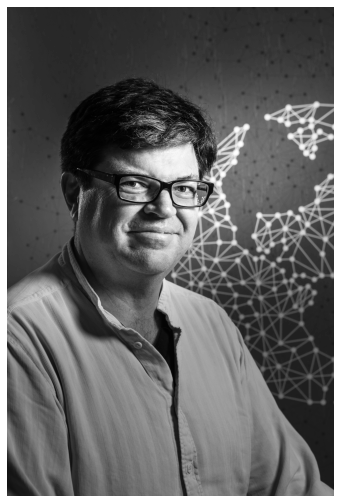

In [27]:
show_grayscale_image(img)

In [28]:
to_tensor = torchvision.transforms.ToTensor()

In [29]:
img_tensor = to_tensor(img)

In [30]:
img_tensor.shape

torch.Size([1, 3960, 2640])

In [31]:
# используем unsqueeze для исправления размерности тензора
img_tensor = torch.unsqueeze(img_tensor, dim=0)

In [32]:
assert img_tensor.shape == torch.Size([1, 1, 3960, 2640])

## Создадим свёртку, которая размоет изображение

In [33]:
kernel_size = 50
layer = torch.nn.Conv2d(1, 1, kernel_size=kernel_size)

In [34]:
# обновим веса так, чтобы получилась свёртка, которая размывает изображение
layer.weight.data = torch.ones_like(layer.weight.data)
layer.weight.data /= torch.sum(layer.weight.data)
layer.bias.data = torch.zeros_like(layer.bias.data)

In [35]:
layer.weight.data

tensor([[[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          ...,
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]]])

In [36]:
layer.eval()

Conv2d(1, 1, kernel_size=(50, 50), stride=(1, 1))

In [37]:
output_tensor = layer(img_tensor)

In [38]:
output_tensor.shape

torch.Size([1, 1, 3911, 2591])

In [39]:
import torchvision.transforms as transforms

# функция, переводящяя тензор в PIL-изображение
to_pil_image = transforms.ToPILImage()

In [40]:
output_img = to_pil_image(output_tensor.squeeze(0))

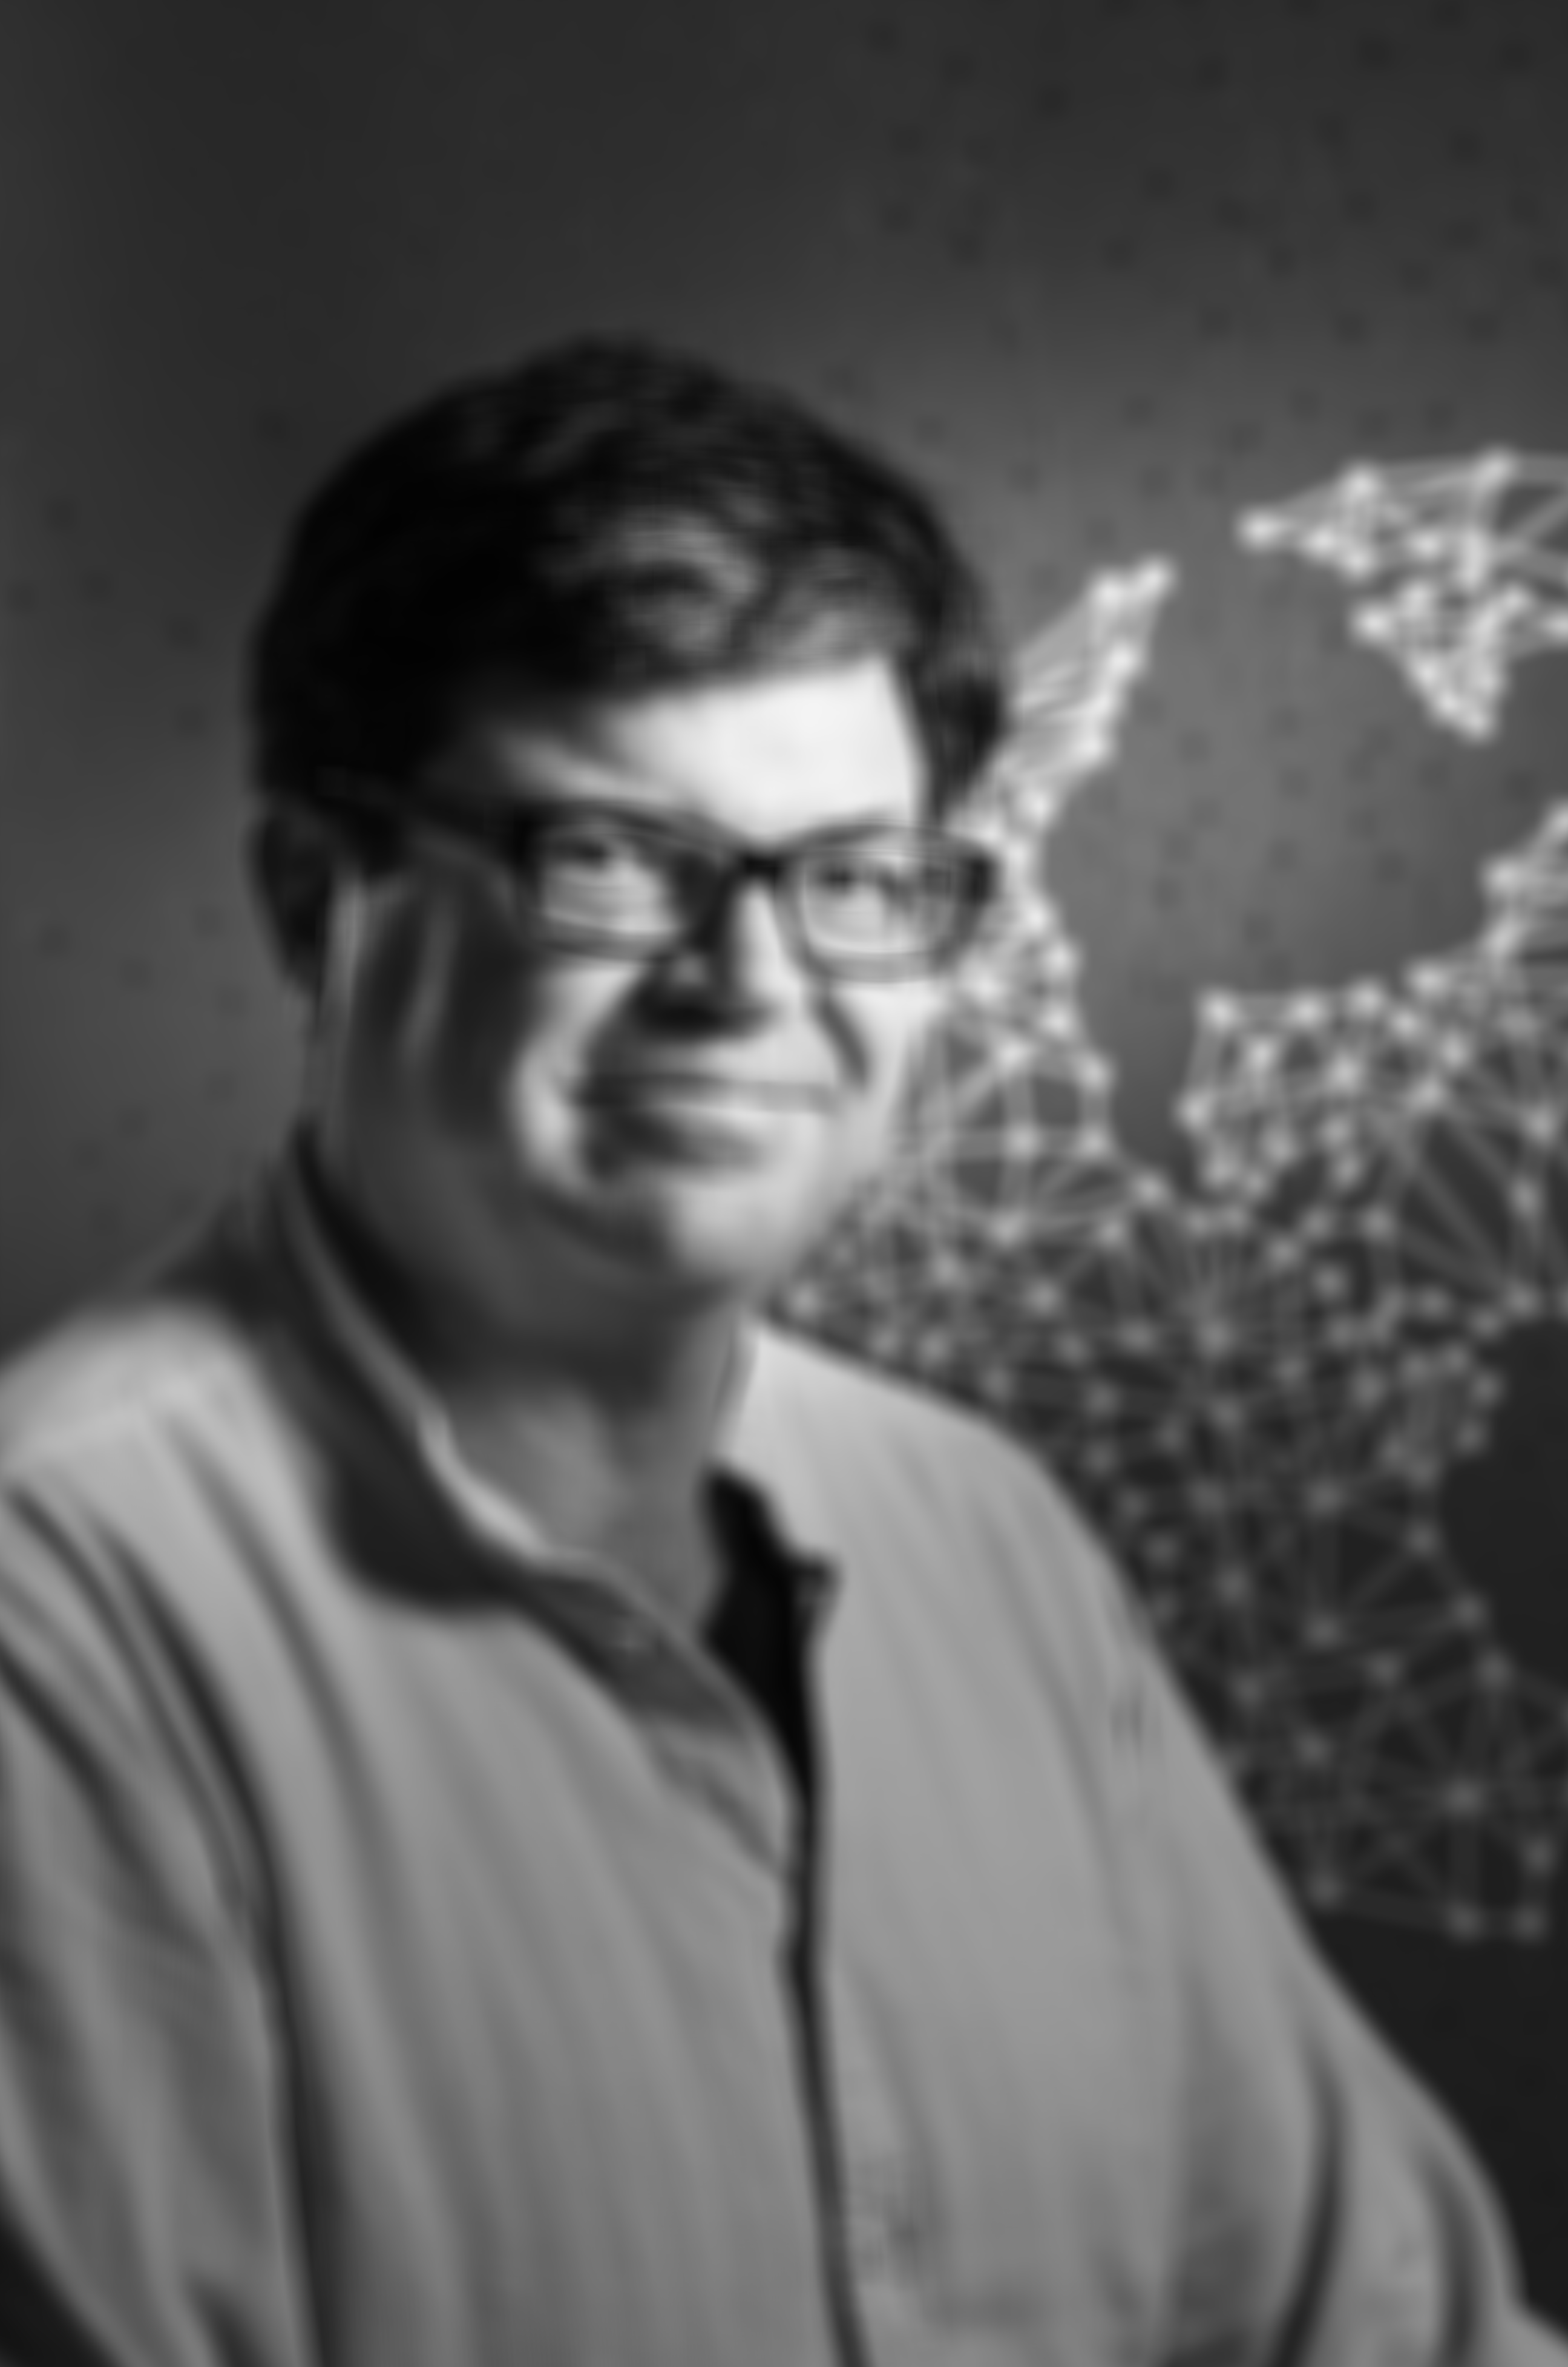

In [41]:
output_img

# Обучение моделей на изображениях

## Данные и преобразования

In [42]:
import torch
import torchvision
import torchvision.transforms as transforms

In [43]:
# зададим последовательность трансформаций, переводящих изображение
# в тензор и нормирующих его

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5)),
])

In [49]:
batch_size = 4

# dataset задаёт данные
trainset = torchvision.datasets.CIFAR10(root='../05-recap-speedup-hopt-17-02-2021//data', train=True,
                                        download=True, transform=transform)

# dataloader загружает их
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../05-recap-speedup-hopt-17-02-2021//data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Отрисовка

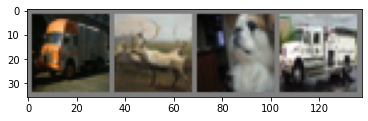

truck deer dog truck


In [52]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5  # убираем нормализацию
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# взять случайный батч изображений
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}'.format(classes[labels[j]]) for j in range(4)))

## Рутина обучения модели

In [53]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # зануляем градинты
            optimizer.zero_grad()

            # производим прямой и обратный проходы
            preds = net(inputs)
            loss = criterion(preds, labels)
            loss.backward()

            # делаем шаг оптимизатором
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(
                    epoch + 1, num_epochs, i + 1, running_loss / 2000))
                running_loss = 0.0
        print()

    print('Finished Training')

    return net

## Точность модели на тестовом наборе данных

In [54]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            preds = net(images)
            predicted = torch.argmax(preds)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {}%'.format(
        100 * correct / total))

In [55]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of {}: {}%'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

## Полносвязная сеть для классификации

In [56]:
import torch.nn as nn
import torch.nn.functional as F


# создадим сеть, состоящую из 3 полносвязных слоёв
# (input_size -> 128, 128 -> 32, 32 -> output_size) 
# и использующую в качестве функции активции ReLU

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [57]:
import torch.optim as optim

net = FeedForwardNet()
# инициализируем критерий и оптимизатор (SGD с моментумом)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [58]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 1.946
Epoch 1/5, iteration 4000, loss: 1.737
Epoch 1/5, iteration 6000, loss: 1.654
Epoch 1/5, iteration 8000, loss: 1.647
Epoch 1/5, iteration 10000, loss: 1.579
Epoch 1/5, iteration 12000, loss: 1.585

Epoch 2/5, iteration 2000, loss: 1.498
Epoch 2/5, iteration 4000, loss: 1.510
Epoch 2/5, iteration 6000, loss: 1.509
Epoch 2/5, iteration 8000, loss: 1.495
Epoch 2/5, iteration 10000, loss: 1.461
Epoch 2/5, iteration 12000, loss: 1.451

Epoch 3/5, iteration 2000, loss: 1.394
Epoch 3/5, iteration 4000, loss: 1.373
Epoch 3/5, iteration 6000, loss: 1.393
Epoch 3/5, iteration 8000, loss: 1.433
Epoch 3/5, iteration 10000, loss: 1.406
Epoch 3/5, iteration 12000, loss: 1.407

Epoch 4/5, iteration 2000, loss: 1.320
Epoch 4/5, iteration 4000, loss: 1.341
Epoch 4/5, iteration 6000, loss: 1.331
Epoch 4/5, iteration 8000, loss: 1.346
Epoch 4/5, iteration 10000, loss: 1.332
Epoch 4/5, iteration 12000, loss: 1.359

Epoch 5/5, iteration 2000, loss: 1.273
Epoch 5/5, it

In [59]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 6.38%


In [60]:
class_accuracy(net, testloader)

Accuracy of plane: 57.6%
Accuracy of car: 60.9%
Accuracy of bird: 28.4%
Accuracy of cat: 10.5%
Accuracy of deer: 42.3%
Accuracy of dog: 55.4%
Accuracy of frog: 74.1%
Accuracy of horse: 54.3%
Accuracy of ship: 63.7%
Accuracy of truck: 55.4%


## Свёрточная сеть для классификации

In [61]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # реализуем прямой проход:
        # conv1 -> relu -> pooling
        # conv2 -> relu -> pooling
        # flatten
        # fc1 -> relu
        # fc2 -> relu
        # fc3
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [62]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 2.161
Epoch 1/5, iteration 4000, loss: 1.838


In [56]:
# сохраним сеть
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

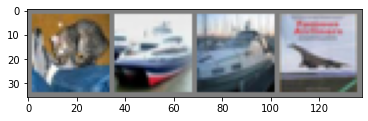

GroundTruth: cat ship ship plane


In [57]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',
      ' '.join('{}'.format(classes[labels[j]]) for j in range(batch_size)))

In [58]:
# загрузим сеть
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [59]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:',
      ' '.join('{}'.format(classes[predicted[j]]) for j in range(4)))

Predicted: cat ship ship plane


In [60]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 7.13%


In [61]:
class_accuracy(net, testloader)

Accuracy of plane: 65.0%
Accuracy of car: 85.7%
Accuracy of bird: 55.0%
Accuracy of cat: 49.9%
Accuracy of deer: 42.1%
Accuracy of dog: 52.1%
Accuracy of frog: 71.7%
Accuracy of horse: 70.5%
Accuracy of ship: 75.8%
Accuracy of truck: 60.4%


### Managing CUDA

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
# inputs, labels = data[0].to(device), data[1].to(device)
# where "data" is given as: for i, data in enumerate(trainloader, 0): ...

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Текстовая версия части этого семинара доступна на официальном сайте Pytorch:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html